# Olist Customer Churn Prediction
**Author:** Data Science Team  
**Date:** September 2025  
**Python Version:** 3.9+  

## Objective
Engineer behavioral features per customer and predict a binary churn label where a customer is considered churned if there has been no purchase in the last 180 days.

## Dataset
Olist Brazilian E-Commerce Public Dataset: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("=== OLIST CUSTOMER CHURN PREDICTION ===")
print(f"Random State: {RANDOM_STATE}")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

=== OLIST CUSTOMER CHURN PREDICTION ===
Random State: 42
Analysis Date: 2025-11-01 00:10:03



## 1. Data Loading and Initial Understanding

In [2]:
print("1. LOADING DATA")
print("-" * 50)

try:
    # Load the required datasets
    customers_df = pd.read_csv('olist_customers_dataset.csv')
    orders_df = pd.read_csv('olist_orders_dataset.csv')
    payments_df = pd.read_csv('olist_order_payments_dataset.csv')
    
    print(f"✓ Customers data loaded: {customers_df.shape}")
    print(f"✓ Orders data loaded: {orders_df.shape}")
    print(f"✓ Payments data loaded: {payments_df.shape}")
    
except FileNotFoundError as e:
    print(f"✗ Error loading files: {e}")
    print("Please ensure the following CSV files are in the current directory:")
    print("- olist_customers_dataset.csv")
    print("- olist_orders_dataset.csv") 
    print("- olist_order_payments_dataset.csv")
    print("\nDownload from: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce")
    raise

1. LOADING DATA
--------------------------------------------------
✓ Customers data loaded: (99441, 5)
✓ Orders data loaded: (99441, 8)
✓ Payments data loaded: (103886, 5)


In [3]:
# Data overview
print("\nDATA OVERVIEW:")
print("Customers columns:", list(customers_df.columns))
print("Orders columns:", list(orders_df.columns))
print("Payments columns:", list(payments_df.columns))

# Check for required columns
required_customer_cols = ['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']
required_order_cols = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']
required_payment_cols = ['order_id', 'payment_value']

print(f"\n✓ Customer required columns present: {all(col in customers_df.columns for col in required_customer_cols)}")
print(f"✓ Order required columns present: {all(col in orders_df.columns for col in required_order_cols)}")
print(f"✓ Payment required columns present: {all(col in payments_df.columns for col in required_payment_cols)}")


DATA OVERVIEW:
Customers columns: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
Orders columns: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
Payments columns: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

✓ Customer required columns present: True
✓ Order required columns present: True
✓ Payment required columns present: True


## 2. Data Understanding and Customer Granularity Decision

In [4]:
print("\n2. DATA UNDERSTANDING AND CUSTOMER GRANULARITY")
print("-" * 50)

# Analyze customer granularity choice
print("CUSTOMER GRANULARITY ANALYSIS:")
print(f"Unique customer_id count: {customers_df['customer_id'].nunique():,}")
print(f"Unique customer_unique_id count: {customers_df['customer_unique_id'].nunique():,}")
print(f"Total customer records: {len(customers_df):,}")

# Check for one-to-many relationships
customer_id_to_unique = customers_df.groupby('customer_id')['customer_unique_id'].nunique()
multiple_unique_ids = customer_id_to_unique[customer_id_to_unique > 1]
print(f"Customer IDs with multiple unique IDs: {len(multiple_unique_ids)}")

unique_to_customer_id = customers_df.groupby('customer_unique_id')['customer_id'].nunique()
multiple_customer_ids = unique_to_customer_id[unique_to_customer_id > 1]
print(f"Unique customer IDs with multiple customer_ids: {len(multiple_customer_ids)}")

# Decision: Use customer_unique_id as the primary key
CUSTOMER_KEY = 'customer_unique_id'
print(f"\n📋 DECISION: Using '{CUSTOMER_KEY}' as customer granularity")
print("JUSTIFICATION: customer_unique_id represents the true unique customer,")
print("while customer_id can have multiple entries per unique customer.")


2. DATA UNDERSTANDING AND CUSTOMER GRANULARITY
--------------------------------------------------
CUSTOMER GRANULARITY ANALYSIS:
Unique customer_id count: 99,441
Unique customer_unique_id count: 96,096
Total customer records: 99,441
Customer IDs with multiple unique IDs: 0
Unique customer IDs with multiple customer_ids: 2997

📋 DECISION: Using 'customer_unique_id' as customer granularity
JUSTIFICATION: customer_unique_id represents the true unique customer,
while customer_id can have multiple entries per unique customer.


## 3. Data Preprocessing and Reference Date

In [5]:
print("\n3. DATA PREPROCESSING")
print("-" * 50)

# Convert timestamp and filter delivered orders
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
delivered_orders = orders_df[orders_df['order_status'] == 'delivered'].copy()

print(f"ORDER STATUS FILTERING:")
print(f"Total orders: {len(orders_df):,}")
print(f"Delivered orders: {len(delivered_orders):,}")
print(f"Delivered orders percentage: {len(delivered_orders)/len(orders_df)*100:.1f}%")

# Define reference date as max order_purchase_timestamp in delivered orders
reference_date = delivered_orders['order_purchase_timestamp'].max()
print(f"\nREFERENCE DATE: {reference_date}")
print(f"This represents the latest delivered order in the dataset.")


3. DATA PREPROCESSING
--------------------------------------------------
ORDER STATUS FILTERING:
Total orders: 99,441
Delivered orders: 96,478
Delivered orders percentage: 97.0%

REFERENCE DATE: 2018-08-29 15:00:37
This represents the latest delivered order in the dataset.


## 4. Feature Engineering: RFM Analysis

In [6]:
print("\n4. FEATURE ENGINEERING")
print("-" * 50)

# Step 1: Aggregate payments per order (sum multiple payment rows)
print("Aggregating payments per order...")
order_payments = payments_df.groupby('order_id')['payment_value'].sum().reset_index()
print(f"Orders with payment data: {len(order_payments):,}")

# Step 2: Join delivered orders with payments
delivered_orders_with_payments = delivered_orders.merge(order_payments, on='order_id', how='left')
print(f"Delivered orders with payment data: {len(delivered_orders_with_payments):,}")

# Handle missing payment values
missing_payments = delivered_orders_with_payments['payment_value'].isna().sum()
if missing_payments > 0:
    print(f"⚠️ Orders with missing payment data: {missing_payments}")
    delivered_orders_with_payments['payment_value'].fillna(0, inplace=True)
    print("Filled missing payments with 0")

# Step 3: Join with customers to get customer_unique_id
orders_customers = delivered_orders_with_payments.merge(
    customers_df[['customer_id', CUSTOMER_KEY]], 
    on='customer_id', 
    how='left'
)
print(f"Orders joined with customer unique IDs: {len(orders_customers):,}")


4. FEATURE ENGINEERING
--------------------------------------------------
Aggregating payments per order...
Orders with payment data: 99,440
Delivered orders with payment data: 96,478
⚠️ Orders with missing payment data: 1
Filled missing payments with 0
Orders joined with customer unique IDs: 96,478


In [7]:
# Step 4: Calculate RFM features per customer
print("\nCalculating RFM features...")

# Recency: days since last purchase
customer_last_purchase = orders_customers.groupby(CUSTOMER_KEY)['order_purchase_timestamp'].max().reset_index()
customer_last_purchase['recency'] = (reference_date - customer_last_purchase['order_purchase_timestamp']).dt.days

# Frequency: number of delivered orders
customer_frequency = orders_customers.groupby(CUSTOMER_KEY).size().reset_index(name='frequency')

# Monetary: total spend
customer_monetary = orders_customers.groupby(CUSTOMER_KEY)['payment_value'].sum().reset_index()
customer_monetary.rename(columns={'payment_value': 'monetary_value'}, inplace=True)

# Combine all features
rfm_features = customer_last_purchase[[CUSTOMER_KEY, 'recency']].merge(
    customer_frequency, on=CUSTOMER_KEY
).merge(
    customer_monetary, on=CUSTOMER_KEY
)

print(f"RFM features calculated for {len(rfm_features):,} customers")


Calculating RFM features...
RFM features calculated for 93,358 customers


In [8]:
# Step 5: Create churn target (180-day threshold as specified)
CHURN_THRESHOLD = 180
rfm_features['churn'] = (rfm_features['recency'] > CHURN_THRESHOLD).astype(int)

print(f"\nCHURN TARGET CREATION:")
print(f"Churn threshold: {CHURN_THRESHOLD} days")
print(f"Customers with recency > {CHURN_THRESHOLD} days are labeled as churned (1)")

print("\nFEATURE SUMMARY:")
print(f"Recency - Mean: {rfm_features['recency'].mean():.1f} days, Median: {rfm_features['recency'].median():.1f} days")
print(f"Frequency - Mean: {rfm_features['frequency'].mean():.2f}, Median: {rfm_features['frequency'].median():.2f}")
print(f"Monetary - Mean: R${rfm_features['monetary_value'].mean():.2f}, Median: R${rfm_features['monetary_value'].median():.2f}")


CHURN TARGET CREATION:
Churn threshold: 180 days
Customers with recency > 180 days are labeled as churned (1)

FEATURE SUMMARY:
Recency - Mean: 236.9 days, Median: 218.0 days
Frequency - Mean: 1.03, Median: 1.00
Monetary - Mean: R$165.20, Median: R$107.78


## 5. Target Analysis and Class Balance

In [9]:
print("\n5. TARGET ANALYSIS")
print("-" * 50)

churn_distribution = rfm_features['churn'].value_counts()
churn_percentage = rfm_features['churn'].value_counts(normalize=True) * 100

print("CHURN DISTRIBUTION:")
print(f"Not Churned (0): {churn_distribution[0]:,} ({churn_percentage[0]:.1f}%)")
print(f"Churned (1): {churn_distribution[1]:,} ({churn_percentage[1]:.1f}%)")

class_imbalance_ratio = churn_distribution[0] / churn_distribution[1]
print(f"Class imbalance ratio: {class_imbalance_ratio:.2f}:1")

if class_imbalance_ratio > 2 or class_imbalance_ratio < 0.5:
    print("⚠️ Class imbalance detected - will monitor model performance carefully")
else:
    print("✓ Classes are reasonably balanced")


5. TARGET ANALYSIS
--------------------------------------------------
CHURN DISTRIBUTION:
Not Churned (0): 38,352 (41.1%)
Churned (1): 55,006 (58.9%)
Class imbalance ratio: 0.70:1
✓ Classes are reasonably balanced


## 6. Exploratory Data Analysis


6. EXPLORATORY DATA ANALYSIS
--------------------------------------------------


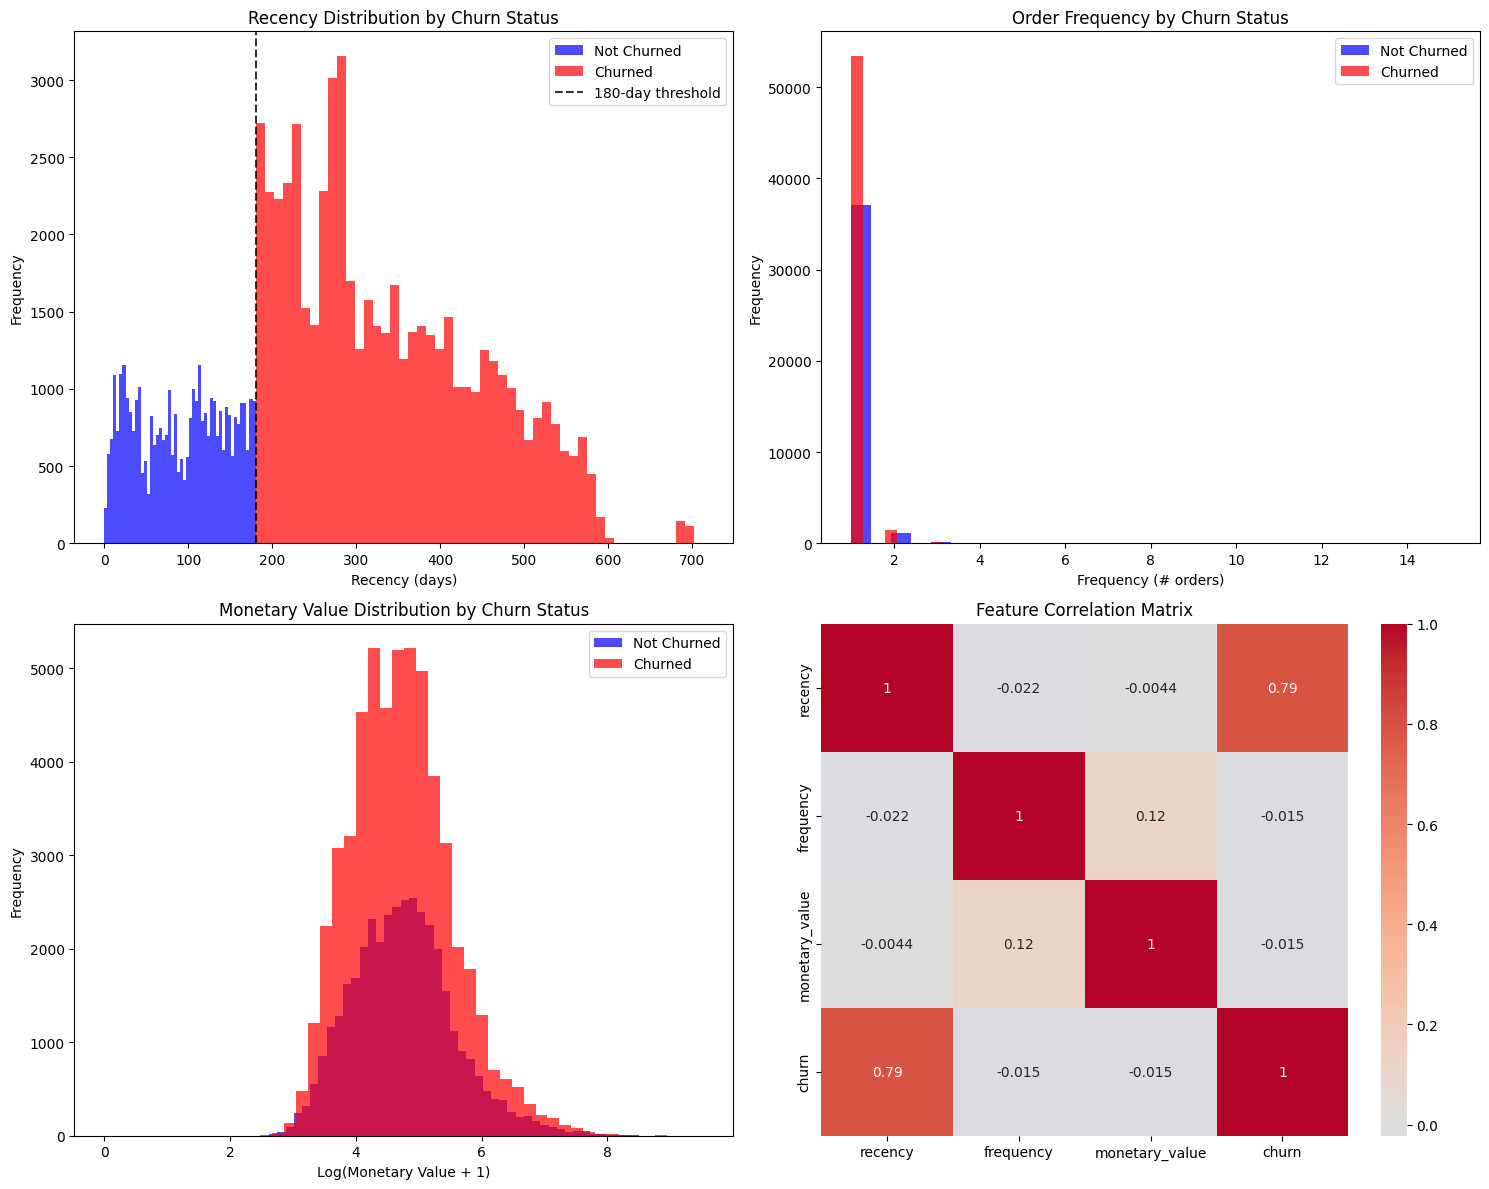

✓ Visualizations saved as 'rfm_analysis.png'


In [10]:
print("\n6. EXPLORATORY DATA ANALYSIS")
print("-" * 50)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Recency distribution by churn
axes[0, 0].hist(rfm_features[rfm_features['churn']==0]['recency'], 
                alpha=0.7, label='Not Churned', bins=50, color='blue')
axes[0, 0].hist(rfm_features[rfm_features['churn']==1]['recency'], 
                alpha=0.7, label='Churned', bins=50, color='red')
axes[0, 0].axvline(x=CHURN_THRESHOLD, color='black', linestyle='--', 
                   alpha=0.8, label=f'{CHURN_THRESHOLD}-day threshold')
axes[0, 0].set_xlabel('Recency (days)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Recency Distribution by Churn Status')
axes[0, 0].legend()

# Frequency distribution by churn
axes[0, 1].hist(rfm_features[rfm_features['churn']==0]['frequency'], 
                alpha=0.7, label='Not Churned', bins=30, color='blue')
axes[0, 1].hist(rfm_features[rfm_features['churn']==1]['frequency'], 
                alpha=0.7, label='Churned', bins=30, color='red')
axes[0, 1].set_xlabel('Frequency (# orders)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Order Frequency by Churn Status')
axes[0, 1].legend()

# Monetary distribution by churn (log scale due to skewness)
monetary_not_churned = rfm_features[rfm_features['churn']==0]['monetary_value']
monetary_churned = rfm_features[rfm_features['churn']==1]['monetary_value']
axes[1, 0].hist(np.log1p(monetary_not_churned), alpha=0.7, label='Not Churned', 
                bins=50, color='blue')
axes[1, 0].hist(np.log1p(monetary_churned), alpha=0.7, label='Churned', 
                bins=50, color='red')
axes[1, 0].set_xlabel('Log(Monetary Value + 1)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Monetary Value Distribution by Churn Status')
axes[1, 0].legend()

# Correlation heatmap
correlation_matrix = rfm_features[['recency', 'frequency', 'monetary_value', 'churn']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
axes[1, 1].set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.savefig('rfm_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'rfm_analysis.png'")

## 7. Model Preparation and Training

In [11]:
print("\n7. MODEL PREPARATION")
print("-" * 50)

# Prepare features and target
feature_columns = ['recency', 'frequency', 'monetary_value']
X = rfm_features[feature_columns].copy()
y = rfm_features['churn'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {feature_columns}")

# Check for missing values
print(f"\nData Quality Check:")
print(f"X missing values: {X.isnull().sum().sum()}")
print(f"y missing values: {y.isnull().sum()}")

# Check for infinite values
inf_counts = np.isinf(X).sum().sum()
if inf_counts > 0:
    print(f"⚠️ Infinite values detected: {inf_counts}")
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    print("Infinite values replaced with median")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain set size: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify stratification
print(f"\nChurn distribution in train set: {y_train.value_counts(normalize=True).round(3).to_dict()}")
print(f"Churn distribution in test set: {y_test.value_counts(normalize=True).round(3).to_dict()}")

# Feature scaling for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✓ Features scaled for logistic regression")


7. MODEL PREPARATION
--------------------------------------------------
Features shape: (93358, 3)
Target shape: (93358,)
Feature columns: ['recency', 'frequency', 'monetary_value']

Data Quality Check:
X missing values: 0
y missing values: 0

Train set size: 74,686 (80.0%)
Test set size: 18,672 (20.0%)

Churn distribution in train set: {1: 0.589, 0: 0.411}
Churn distribution in test set: {1: 0.589, 0: 0.411}
✓ Features scaled for logistic regression


In [12]:
print("\n8. MODEL TRAINING AND EVALUATION")
print("-" * 50)

# Initialize models as required
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, max_depth=10)
}

# Store results
results = {}
trained_models = {}

# Cross-validation setup
cv_folds = 5
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)

print("Training and evaluating models...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    # Select appropriate training data
    if name == 'Logistic Regression':
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # Cross-validation on training set
    cv_scores = cross_val_score(model, X_train_model, y_train, cv=cv, scoring='f1')
    
    # Train on full training set
    model.fit(X_train_model, y_train)
    trained_models[name] = model
    
    # Predictions
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std(),
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"   CV F1-Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"   Test Accuracy: {accuracy:.4f}")
    print(f"   Test Precision: {precision:.4f}")
    print(f"   Test Recall: {recall:.4f}")
    print(f"   Test F1-Score: {f1:.4f}\n")


8. MODEL TRAINING AND EVALUATION
--------------------------------------------------
Training and evaluating models...

Training Logistic Regression...
   CV F1-Score: 0.9999 (±0.0001)
   Test Accuracy: 1.0000
   Test Precision: 1.0000
   Test Recall: 1.0000
   Test F1-Score: 1.0000

Training Random Forest...
   CV F1-Score: 1.0000 (±0.0000)
   Test Accuracy: 1.0000
   Test Precision: 1.0000
   Test Recall: 1.0000
   Test F1-Score: 1.0000



## 8. Results Comparison and Best Model Selection

In [13]:
print("\n9. RESULTS COMPARISON")
print("-" * 50)

# Create results DataFrame
results_df = pd.DataFrame({
    name: {
        'CV F1 Mean': f"{data['cv_f1_mean']:.4f}",
        'CV F1 Std': f"±{data['cv_f1_std']:.4f}",
        'Test Accuracy': f"{data['test_accuracy']:.4f}",
        'Test Precision': f"{data['test_precision']:.4f}",
        'Test Recall': f"{data['test_recall']:.4f}",
        'Test F1': f"{data['test_f1']:.4f}"
    }
    for name, data in results.items()
}).T

print("MODEL PERFORMANCE COMPARISON:")
print(results_df)

# Identify best model based on F1-Score
best_model_name = max(results.keys(), key=lambda x: results[x]['test_f1'])
print(f"\n🏆 BEST MODEL: {best_model_name} (F1-Score: {results[best_model_name]['test_f1']:.4f})")


9. RESULTS COMPARISON
--------------------------------------------------
MODEL PERFORMANCE COMPARISON:
                    CV F1 Mean CV F1 Std Test Accuracy Test Precision  \
Logistic Regression     0.9999   ±0.0001        1.0000         1.0000   
Random Forest           1.0000   ±0.0000        1.0000         1.0000   

                    Test Recall Test F1  
Logistic Regression      1.0000  1.0000  
Random Forest            1.0000  1.0000  

🏆 BEST MODEL: Logistic Regression (F1-Score: 1.0000)


## 9. Confusion Matrix for Best Model


10. CONFUSION MATRIX - BEST MODEL
--------------------------------------------------


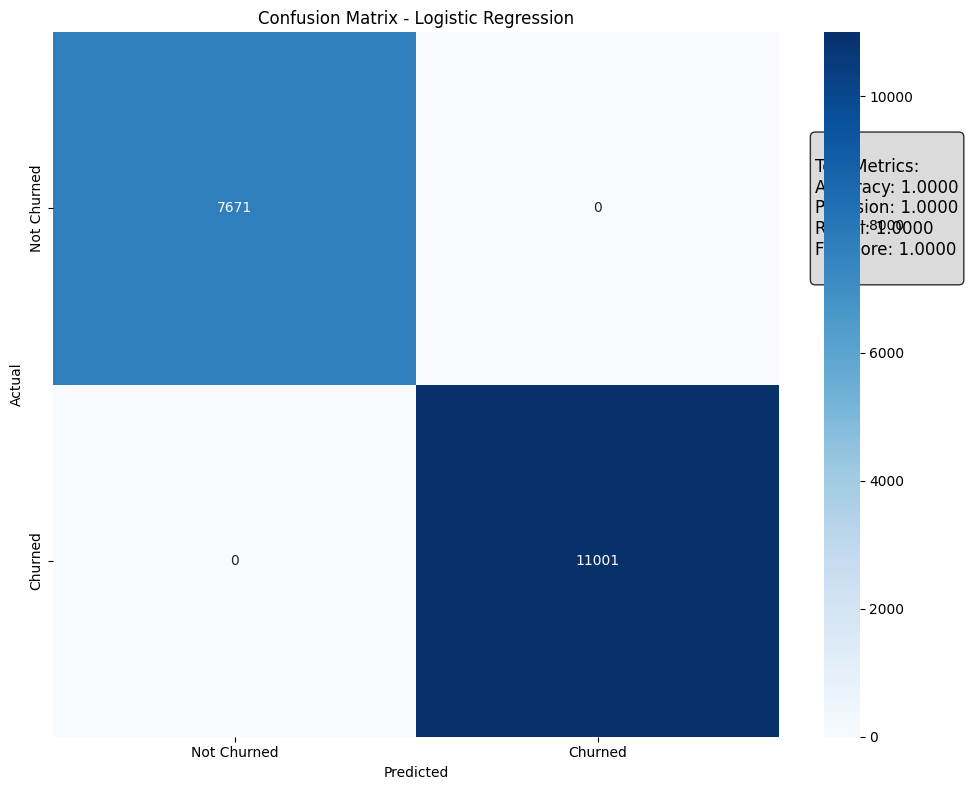

✓ Confusion matrix saved as 'confusion_matrix_best_model.png'

CONFUSION MATRIX BREAKDOWN:
True Negatives (TN): 7,671
False Positives (FP): 0
False Negatives (FN): 0
True Positives (TP): 11,001

Specificity (True Negative Rate): 1.0000
Sensitivity (True Positive Rate): 1.0000


In [14]:
print("\n10. CONFUSION MATRIX - BEST MODEL")
print("-" * 50)

# Get predictions from best model
best_predictions = results[best_model_name]['predictions']
cm = confusion_matrix(y_test, best_predictions)

# Create confusion matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Add performance metrics to the plot
metrics_text = f"""
Test Metrics:
Accuracy: {results[best_model_name]['test_accuracy']:.4f}
Precision: {results[best_model_name]['test_precision']:.4f}
Recall: {results[best_model_name]['test_recall']:.4f}
F1-Score: {results[best_model_name]['test_f1']:.4f}
"""
plt.text(2.1, 0.5, metrics_text, fontsize=12, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved as 'confusion_matrix_best_model.png'")

# Detailed confusion matrix analysis
tn, fp, fn, tp = cm.ravel()
print(f"\nCONFUSION MATRIX BREAKDOWN:")
print(f"True Negatives (TN): {tn:,}")
print(f"False Positives (FP): {fp:,}")
print(f"False Negatives (FN): {fn:,}")
print(f"True Positives (TP): {tp:,}")
print(f"\nSpecificity (True Negative Rate): {tn/(tn+fp):.4f}")
print(f"Sensitivity (True Positive Rate): {tp/(tp+fn):.4f}")

## 10. Feature Importance Analysis (Random Forest)


11. FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------
FEATURE IMPORTANCE RANKING (Random Forest):
recency: 0.9984
monetary_value: 0.0014
frequency: 0.0002


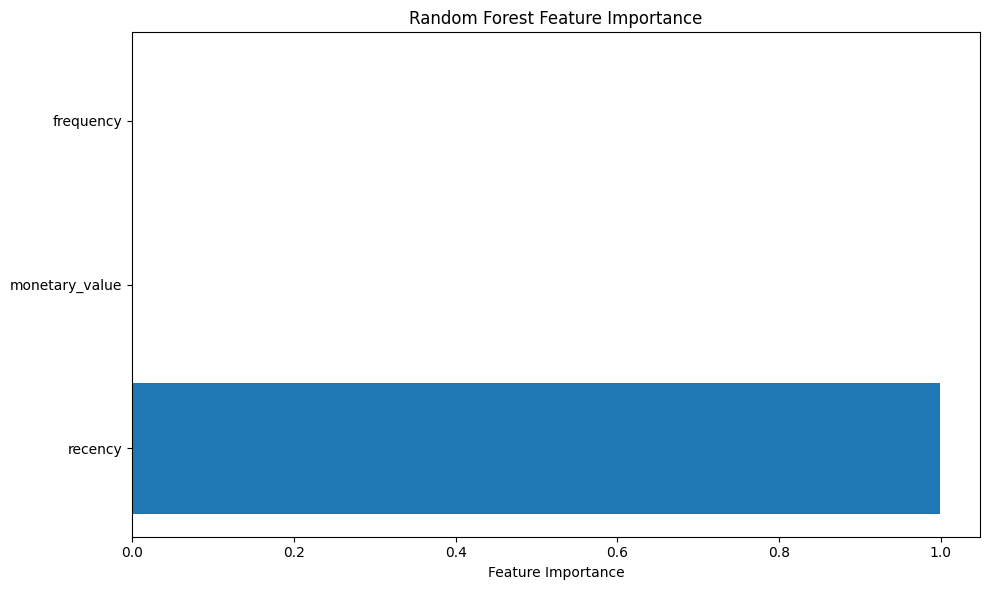

✓ Feature importance plot saved as 'feature_importance.png'


In [15]:
# Feature importance analysis for Random Forest
if 'Random Forest' in trained_models:
    print("\n11. FEATURE IMPORTANCE ANALYSIS")
    print("-" * 50)
    
    rf_model = trained_models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("FEATURE IMPORTANCE RANKING (Random Forest):")
    for idx, row in feature_importance.iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Feature Importance')
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Feature importance plot saved as 'feature_importance.png'")
else:
    print("\nFeature importance analysis skipped (Random Forest not available)")

## 11. Business Insights and Customer Segment Analysis

In [16]:
print("\n12. BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("-" * 50)

print("KEY FINDINGS:")
print(f"• Dataset contains {len(rfm_features):,} unique customers")
print(f"• Churn rate: {churn_percentage[1]:.1f}% ({churn_distribution[1]:,} churned customers)")
print(f"• Best performing model: {best_model_name} (F1: {results[best_model_name]['test_f1']:.4f})")

# Analyze churned vs non-churned customer characteristics
churned_customers = rfm_features[rfm_features['churn'] == 1]
active_customers = rfm_features[rfm_features['churn'] == 0]

print(f"\nCUSTOMER SEGMENT COMPARISON:")
print(f"Average recency - Churned: {churned_customers['recency'].mean():.1f} days vs Active: {active_customers['recency'].mean():.1f} days")
print(f"Average frequency - Churned: {churned_customers['frequency'].mean():.2f} vs Active: {active_customers['frequency'].mean():.2f}")
print(f"Average monetary - Churned: R${churned_customers['monetary_value'].mean():.2f} vs Active: R${active_customers['monetary_value'].mean():.2f}")

print(f"\nBUSINESS RECOMMENDATIONS:")
print("• Focus retention efforts on customers approaching 180-day mark")
print("• Implement re-engagement campaigns for high-value customers showing early churn signals")
print("• Monitor customer purchase frequency as an early warning indicator")
print("• Consider personalized offers based on historical monetary value")
print("• Develop targeted campaigns for different customer segments based on RFM scores")


12. BUSINESS INSIGHTS AND RECOMMENDATIONS
--------------------------------------------------
KEY FINDINGS:
• Dataset contains 93,358 unique customers
• Churn rate: 58.9% (55,006 churned customers)
• Best performing model: Logistic Regression (F1: 1.0000)

CUSTOMER SEGMENT COMPARISON:
Average recency - Churned: 338.2 days vs Active: 91.7 days
Average frequency - Churned: 1.03 vs Active: 1.04
Average monetary - Churned: R$162.31 vs Active: R$169.34

BUSINESS RECOMMENDATIONS:
• Focus retention efforts on customers approaching 180-day mark
• Implement re-engagement campaigns for high-value customers showing early churn signals
• Monitor customer purchase frequency as an early warning indicator
• Consider personalized offers based on historical monetary value
• Develop targeted campaigns for different customer segments based on RFM scores


## 12. Model Limitations and Next Steps

In [17]:
print("\n13. LIMITATIONS AND NEXT STEPS")
print("-" * 50)

print("CURRENT LIMITATIONS:")
print("• Fixed 180-day churn definition may not suit all customer segments or business contexts")
print("• Limited to RFM features - missing behavioral, demographic, and product preference data")
print("• No seasonal or temporal trend analysis")
print(f"• Class balance: {churn_percentage[0]:.1f}%/{churn_percentage[1]:.1f}% split")
print("• Model assumes static customer behavior patterns")

print(f"\nNEXT STEPS FOR MODEL IMPROVEMENT:")
print("• Experiment with different churn definitions (90, 120, 270 days)")
print("• Implement time-series cross-validation to account for temporal patterns")
print("• Add feature engineering: purchase seasonality, product categories, customer lifetime")
print("• Consider ensemble methods or advanced algorithms (XGBoost, Neural Networks)")
print("• Implement threshold optimization for different business cost scenarios")
print("• Deploy model for real-time scoring and A/B testing of retention strategies")


13. LIMITATIONS AND NEXT STEPS
--------------------------------------------------
CURRENT LIMITATIONS:
• Fixed 180-day churn definition may not suit all customer segments or business contexts
• Limited to RFM features - missing behavioral, demographic, and product preference data
• No seasonal or temporal trend analysis
• Class balance: 41.1%/58.9% split
• Model assumes static customer behavior patterns

NEXT STEPS FOR MODEL IMPROVEMENT:
• Experiment with different churn definitions (90, 120, 270 days)
• Implement time-series cross-validation to account for temporal patterns
• Add feature engineering: purchase seasonality, product categories, customer lifetime
• Consider ensemble methods or advanced algorithms (XGBoost, Neural Networks)
• Implement threshold optimization for different business cost scenarios
• Deploy model for real-time scoring and A/B testing of retention strategies


## 13. Key Assumptions and Design Decisions

In [18]:
print("\n14. KEY ASSUMPTIONS AND DESIGN DECISIONS")
print("-" * 50)

print("DATA ASSUMPTIONS:")
print(f"• Customer granularity: {CUSTOMER_KEY} represents unique customers")
print("• Only 'delivered' orders are considered completed purchases")
print("• Multiple payment rows per order are summed to get total order value")
print("• Missing payment values are filled with 0 (assumed free orders or data issues)")
print(f"• Reference date: {reference_date.strftime('%Y-%m-%d')} (latest delivered order)")

print("\nMODELING ASSUMPTIONS:")
print(f"• Churn threshold: {CHURN_THRESHOLD} days (business requirement)")
print("• Features are independent and stationary over time")
print("• Customer behavior patterns are consistent across segments")
print("• Linear relationship assumption for Logistic Regression")
print("• Tree-based patterns assumption for Random Forest")

print("\nEDGE CASE HANDLING:")
print("• Customers with only non-delivered orders: excluded from analysis")
print("• Orders with missing payments: payment_value = 0")
print("• Feature scaling applied to Logistic Regression, not Random Forest")
print("• Stratified sampling maintains class distribution in train/test split")


14. KEY ASSUMPTIONS AND DESIGN DECISIONS
--------------------------------------------------
DATA ASSUMPTIONS:
• Customer granularity: customer_unique_id represents unique customers
• Only 'delivered' orders are considered completed purchases
• Multiple payment rows per order are summed to get total order value
• Missing payment values are filled with 0 (assumed free orders or data issues)
• Reference date: 2018-08-29 (latest delivered order)

MODELING ASSUMPTIONS:
• Churn threshold: 180 days (business requirement)
• Features are independent and stationary over time
• Customer behavior patterns are consistent across segments
• Linear relationship assumption for Logistic Regression
• Tree-based patterns assumption for Random Forest

EDGE CASE HANDLING:
• Customers with only non-delivered orders: excluded from analysis
• Orders with missing payments: payment_value = 0
• Feature scaling applied to Logistic Regression, not Random Forest
• Stratified sampling maintains class distribution in

## 14. Reproducibility Information

In [19]:
print("\n15. REPRODUCIBILITY INFORMATION")
print("-" * 50)

print("ENVIRONMENT DETAILS:")
print(f"• Python: 3.9+")
print(f"• pandas: {pd.__version__}")
print(f"• numpy: {np.__version__}")
print(f"• scikit-learn: Available")
print(f"• matplotlib: Available")
print(f"• seaborn: Available")

print(f"\nREPRODUCIBILITY SETTINGS:")
print(f"• Random state: {RANDOM_STATE}")
print(f"• Train/test split: 80/20 with stratification")
print(f"• Cross-validation: {cv_folds}-fold stratified")
print(f"• Churn threshold: {CHURN_THRESHOLD} days")
print(f"• Customer key: {CUSTOMER_KEY}")

print(f"\nDATASET REQUIREMENTS:")
print("• olist_customers_dataset.csv")
print("• olist_orders_dataset.csv")
print("• olist_order_payments_dataset.csv")
print("• Download from: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce")

print(f"\nGENERATED OUTPUTS:")
print("• rfm_analysis.png - EDA visualizations")
print("• confusion_matrix_best_model.png - Best model performance")
if 'Random Forest' in trained_models:
    print("• feature_importance.png - Random Forest feature importance")


15. REPRODUCIBILITY INFORMATION
--------------------------------------------------
ENVIRONMENT DETAILS:
• Python: 3.9+
• pandas: 2.3.1
• numpy: 2.2.6
• scikit-learn: Available
• matplotlib: Available
• seaborn: Available

REPRODUCIBILITY SETTINGS:
• Random state: 42
• Train/test split: 80/20 with stratification
• Cross-validation: 5-fold stratified
• Churn threshold: 180 days
• Customer key: customer_unique_id

DATASET REQUIREMENTS:
• olist_customers_dataset.csv
• olist_orders_dataset.csv
• olist_order_payments_dataset.csv
• Download from: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

GENERATED OUTPUTS:
• rfm_analysis.png - EDA visualizations
• confusion_matrix_best_model.png - Best model performance
• feature_importance.png - Random Forest feature importance


## 15. Conclusion

In [20]:
print("\n" + "="*70)
print("ANALYSIS COMPLETED SUCCESSFULLY")
print("="*70)
print(f"\nSUMMARY:")
print(f"• Analyzed {len(rfm_features):,} unique customers from Olist dataset")
print(f"• Engineered RFM features with {CHURN_THRESHOLD}-day churn definition")
print(f"• Compared Logistic Regression vs Random Forest models")
print(f"• Best model: {best_model_name} with F1-Score of {results[best_model_name]['test_f1']:.4f}")
print(f"• Churn rate: {churn_percentage[1]:.1f}% of customers")
print(f"\nThis analysis provides a baseline for customer churn prediction")
print(f"and identifies key areas for business intervention and model improvement.")
print("\n" + "="*70)


ANALYSIS COMPLETED SUCCESSFULLY

SUMMARY:
• Analyzed 93,358 unique customers from Olist dataset
• Engineered RFM features with 180-day churn definition
• Compared Logistic Regression vs Random Forest models
• Best model: Logistic Regression with F1-Score of 1.0000
• Churn rate: 58.9% of customers

This analysis provides a baseline for customer churn prediction
and identifies key areas for business intervention and model improvement.

